In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

from tqdm.autonotebook import tqdm

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 1000

### Create dataloder

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw




Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw




Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw




Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

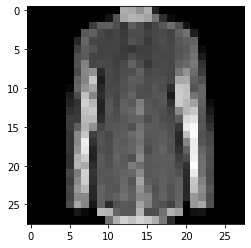

In [6]:
for image, cat in dataloader:
    plt.imshow(image[0].numpy().reshape(28, 28), cmap='gray')
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

In [8]:
28*28

784

### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками. (Опционально)Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### Funcs

In [43]:
def train(generator, discriminator, criterion, verbose=True, with_cat=False, device=None, device_after=None):

    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    device_after = device_after or 'cpu'
    print(f'Device: {device}')
    generator.to(device)
    discriminator.to(device)

    optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
    optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

    input = Variable(torch.FloatTensor(config.batch_size, 28*28)).to(device)
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).to(device)
    fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
    label = Variable(torch.FloatTensor(config.batch_size)).to(device)
    real_label = 1
    fake_label = 0

    ERRD_x = np.zeros(config.num_epochs)
    ERRD_z = np.zeros(config.num_epochs)
    ERRG = np.zeros(config.num_epochs)
    N = len(dataloader)

    max_print_len = 0

    try:
        for epoch in tqdm(range(config.num_epochs)):
            for iteration, (images, cat) in enumerate(dataloader):
                ####### 
                # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
                #######
                images = images.to(device)
                cat = cat.to(device)
                discriminator.zero_grad()
                
                # real
                label.data.fill_(real_label)
                input_data = images.view(images.shape[0], -1)
                if with_cat:
                    output = discriminator(input_data, cat)
                else:
                    output = discriminator(input_data)
                errD_x = criterion(output, label)
                ERRD_x[epoch] += errD_x.item()
                errD_x.backward()
                
                # fake 
                fake_cat = Variable(torch.LongTensor(np.random.randint(0, 10, config.batch_size))).to(device)
                noise.data.normal_(0, 1)
                label.data.fill_(fake_label)
                if with_cat:
                    fake = generator(noise, fake_cat)
                    output = discriminator(fake.detach(), fake_cat)
                else:
                    fake = generator(noise)
                    output = discriminator(fake.detach())
                errD_z = criterion(output, label)
                ERRD_z[epoch] += errD_z.item()
                errD_z.backward()
                
                optim_D.step()
                
                ####### 
                # Generator stage: maximize log(D(G(x))
                #######
                generator.zero_grad()
                label.data.fill_(real_label)
                if with_cat:
                    output = discriminator(fake, fake_cat)
                else:
                    output = discriminator(fake)
                errG = criterion(output, label)
                ERRG[epoch] += errG.item()
                errG.backward()
                
                optim_G.step()

                text = '\rEpoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                                iteration+1, 
                                                                                                    errD_x.item(),
                                                                                                    errD_z.item(), 
                                                                                                    errG.item())
                end = '\n' if (iteration+1) % config.print_freq == 0 else ''

                max_print_len = max(max_print_len, len(text))
                if verbose:
                    print('\r' + ' ' * max_print_len, end='')
                    print(text, end=end)
    except KeyboardInterrupt:
        pass
    finally:
        generator.to(device_after)
        discriminator.to(device_after)

    return ERRD_x, ERRD_z, ERRG

In [21]:
def plot_loss(ERRD_x, ERRD_z, ERRG):
    plt.figure(figsize=(10, 5))
    plt.plot(ERRD_x, label="real")
    plt.plot(ERRD_z, label="fake")
    plt.plot(ERRG, label="generator")
    plt.legend()
    plt.show()

In [22]:
def make_samples(generator, with_cat=False):
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
    noise.data.normal_(0, 1)
    fake_cat = Variable(torch.LongTensor(np.random.randint(0, 10, config.batch_size)))
    if with_cat:
        fake = generator(noise, fake_cat)
    else:
        fake = generator(noise)

    plt.figure(figsize=(6, 7))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.axis('off')
    plt.show()

### GAN

In [52]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x).view(-1)

Device: cuda


Epoch:1 Iter: 1000 errD_x: 0.44 errD_z: 0.11 errG: 2.53
Epoch:1 Iter: 2000 errD_x: 0.17 errD_z: 0.18 errG: 2.55
Epoch:1 Iter: 3000 errD_x: 0.16 errD_z: 0.03 errG: 4.26
Epoch:2 Iter: 1000 errD_x: 0.08 errD_z: 0.42 errG: 1.86
Epoch:2 Iter: 2000 errD_x: 0.04 errD_z: 0.15 errG: 2.83
Epoch:2 Iter: 3000 errD_x: 0.02 errD_z: 0.23 errG: 2.93
Epoch:3 Iter: 1000 errD_x: 0.13 errD_z: 0.48 errG: 1.71
Epoch:3 Iter: 2000 errD_x: 0.23 errD_z: 0.21 errG: 2.46
Epoch:3 Iter: 3000 errD_x: 0.26 errD_z: 0.20 errG: 2.29
Epoch:4 Iter: 1000 errD_x: 0.30 errD_z: 0.10 errG: 3.00
Epoch:4 Iter: 2000 errD_x: 0.13 errD_z: 0.31 errG: 2.28
Epoch:4 Iter: 3000 errD_x: 0.05 errD_z: 0.25 errG: 2.48
Epoch:5 Iter: 1000 errD_x: 0.04 errD_z: 0.06 errG: 3.69
Epoch:5 Iter: 2000 errD_x: 0.51 errD_z: 0.08 errG: 3.17
Epoch:5 Iter: 3000 errD_x: 0.70 errD_z: 0.12 errG: 3.42
Epoch:6 Iter: 1000 errD_x: 0.62 errD_z: 0.10 errG: 2.32
Epoch:6 Iter: 2000 errD_x: 0.62 errD_z: 0.07 errG: 3.04
Epoch:6 Iter: 3000 errD_x: 0.33 errD_z: 0.24 err

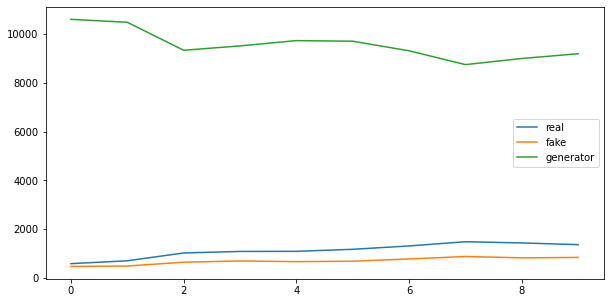

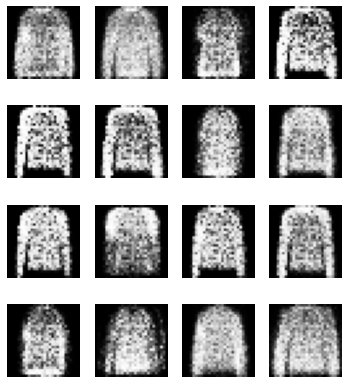

CPU times: user 3min 45s, sys: 11.5 s, total: 3min 56s
Wall time: 3min 49s


In [53]:
%%time
generator = Generator()
discriminator = Discriminator()
criterion = nn.BCELoss()
ERRD_x, ERRD_z, ERRG = train(generator, discriminator, nn.BCELoss())
plot_loss(ERRD_x, ERRD_z, ERRG)
make_samples(generator)

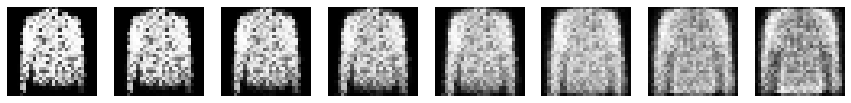

In [54]:
noise1 = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
noise1.data.normal_(0, 1)
noise2 = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
noise2.data.normal_(0, 1)
diff = noise1 - noise2

plt.figure(figsize=(15, 15))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    fake = generator(noise2 + (i / 7) * diff)
    plt.imshow(fake[0].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### DCGAN

In [46]:
class DCGenerator(nn.Module):
    def __init__(self):
        super(DCGenerator, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(config.noise_size, 64 * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64 * 2, 64, kernel_size=2, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, inputs):
        inputs = inputs.view(-1, config.noise_size, 1, 1)
        outputs = self.model(inputs)
        return outputs
    
class DCDiscriminator(nn.Module):
    def __init__(self):
        super(DCDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        inputs = inputs.view(-1, 1, 28, 28)
        outputs = self.model(inputs)
        return outputs.view(-1)

Device: cuda


Epoch:1 Iter: 1000 errD_x: 0.64 errD_z: 0.34 errG: 1.30
Epoch:1 Iter: 2000 errD_x: 0.18 errD_z: 0.25 errG: 1.62
Epoch:1 Iter: 3000 errD_x: 0.19 errD_z: 0.20 errG: 1.77
Epoch:2 Iter: 1000 errD_x: 0.18 errD_z: 0.14 errG: 2.27
Epoch:2 Iter: 2000 errD_x: 0.07 errD_z: 0.12 errG: 2.52
Epoch:2 Iter: 3000 errD_x: 0.06 errD_z: 0.10 errG: 2.79
Epoch:3 Iter: 1000 errD_x: 0.18 errD_z: 0.04 errG: 3.57
Epoch:3 Iter: 2000 errD_x: 0.04 errD_z: 0.03 errG: 3.54
Epoch:3 Iter: 3000 errD_x: 0.17 errD_z: 0.03 errG: 3.59
Epoch:4 Iter: 1000 errD_x: 0.00 errD_z: 0.03 errG: 3.70
Epoch:4 Iter: 2000 errD_x: 0.00 errD_z: 0.03 errG: 4.02
Epoch:4 Iter: 3000 errD_x: 0.01 errD_z: 0.03 errG: 3.90
Epoch:5 Iter: 1000 errD_x: 0.01 errD_z: 0.02 errG: 4.05
Epoch:5 Iter: 2000 errD_x: 0.01 errD_z: 0.04 errG: 4.41
Epoch:5 Iter: 3000 errD_x: 0.03 errD_z: 0.04 errG: 4.31
Epoch:6 Iter: 1000 errD_x: 0.03 errD_z: 0.01 errG: 5.02
Epoch:6 Iter: 2000 errD_x: 0.00 errD_z: 0.01 errG: 5.29
Epoch:6 Iter: 3000 errD_x: 0.00 errD_z: 0.07 err

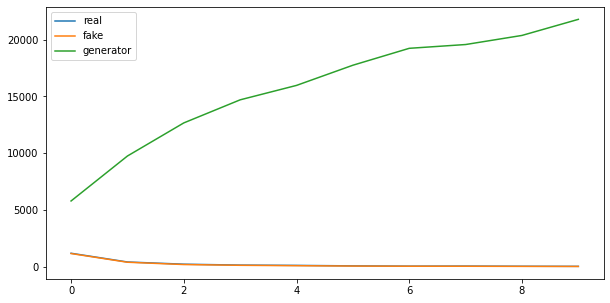

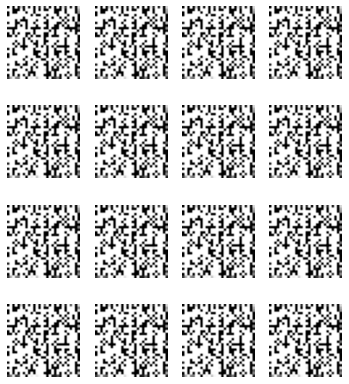

CPU times: user 12min 25s, sys: 14 s, total: 12min 39s
Wall time: 12min 38s


In [47]:
%%time
generator = DCGenerator()
discriminator = DCDiscriminator()
criterion = nn.BCELoss()
ERRD_x, ERRD_z, ERRG = train(generator, discriminator, criterion)
plot_loss(ERRD_x, ERRD_z, ERRG)
make_samples(generator)

### LSGAN

In [48]:
class LSGenerator(nn.Module):
    def __init__(self):
        super(LSGenerator, self).__init__()
        tr_size = 256  # 256
        self.model = nn.Sequential( 
            nn.ConvTranspose2d(config.noise_size, tr_size, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(tr_size),
            nn.ConvTranspose2d(tr_size, tr_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(tr_size),
            nn.ConvTranspose2d(tr_size, tr_size, kernel_size=6, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(tr_size),
            nn.ConvTranspose2d(tr_size, tr_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(tr_size),
            nn.ConvTranspose2d(tr_size, tr_size // 2, kernel_size=6, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(tr_size // 2),
            nn.ConvTranspose2d(tr_size // 2, tr_size // 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(tr_size // 4),
            nn.ConvTranspose2d(tr_size // 4, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = x.view(-1, config.noise_size, 1, 1)
        x = self.model(x)
        return x
    
class LSDiscriminator(nn.Module):
    def __init__(self):
        super(LSDiscriminator, self).__init__()
        tr_size = 64  # 64
        self.linear_size = 2 * 2 * tr_size * 8
        self.model = nn.Sequential(
            nn.Conv2d(1, tr_size, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(tr_size),
            nn.Conv2d(tr_size, tr_size * 2, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(tr_size * 2),
            nn.Conv2d(tr_size * 2, tr_size * 4, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(tr_size * 4),
            nn.Conv2d(tr_size * 4, tr_size * 8, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(tr_size * 8),
        )
        self.linear = nn.Sequential(nn.Linear(self.linear_size, 1), nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.model(x)
        x = x.view(-1, self.linear_size)
        x = self.linear(x)
        return x.view(-1)

Device: cuda


Epoch:1 Iter: 1000 errD_x: 0.00 errD_z: 0.00 errG: 11.14
Epoch:1 Iter: 2000 errD_x: 0.07 errD_z: 0.00 errG: 11.15
Epoch:1 Iter: 3000 errD_x: 0.00 errD_z: 0.00 errG: 8.91
Epoch:2 Iter: 1000 errD_x: 0.00 errD_z: 0.00 errG: 14.21
Epoch:2 Iter: 2000 errD_x: 0.00 errD_z: 0.00 errG: 12.49
Epoch:2 Iter: 3000 errD_x: 0.00 errD_z: 0.00 errG: 10.23
Epoch:3 Iter: 1000 errD_x: 0.04 errD_z: 0.68 errG: 2.91
Epoch:3 Iter: 2000 errD_x: 0.04 errD_z: 0.00 errG: 7.48
Epoch:3 Iter: 3000 errD_x: 0.08 errD_z: 0.00 errG: 8.02
Epoch:4 Iter: 1000 errD_x: 0.00 errD_z: 0.01 errG: 5.62
Epoch:4 Iter: 2000 errD_x: 0.00 errD_z: 0.00 errG: 8.70
Epoch:4 Iter: 3000 errD_x: 0.05 errD_z: 0.07 errG: 4.00
Epoch:5 Iter: 1000 errD_x: 0.04 errD_z: 0.01 errG: 5.32
Epoch:5 Iter: 2000 errD_x: 0.11 errD_z: 0.00 errG: 15.31
Epoch:5 Iter: 3000 errD_x: 0.00 errD_z: 0.00 errG: 5.83
Epoch:6 Iter: 1000 errD_x: 0.00 errD_z: 0.00 errG: 15.92
Epoch:6 Iter: 2000 errD_x: 0.00 errD_z: 0.00 errG: 8.32
Epoch:6 Iter: 3000 errD_x: 0.00 errD_z: 0

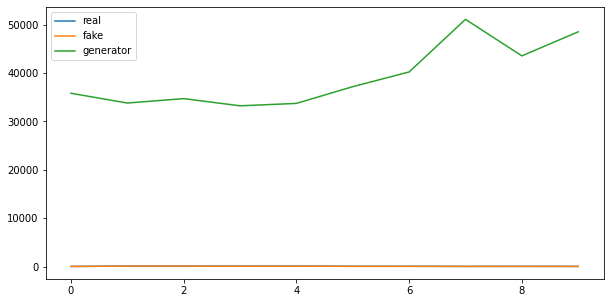

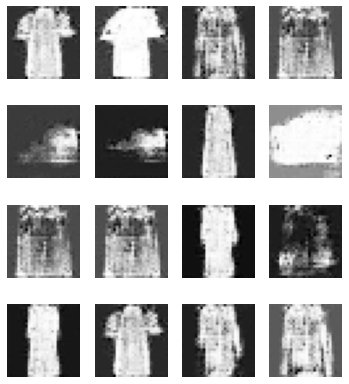

CPU times: user 40min 13s, sys: 17.8 s, total: 40min 31s
Wall time: 40min 35s


In [49]:
%%time
generator = LSGenerator()
discriminator = LSDiscriminator()
criterion = nn.BCELoss()
ERRD_x, ERRD_z, ERRG = train(generator, discriminator, criterion)
plot_loss(ERRD_x, ERRD_z, ERRG)
make_samples(generator)

### CondGAN

In [50]:
class CondGenerator(nn.Module):
    def __init__(self):
        super(CondGenerator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
    
    def forward(self, x, labels):
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)


class CondDiscriminator(nn.Module):
    def __init__(self):
        super(CondDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(28*28 + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    
    def forward(self, x, labels):
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        return self.model(x).view(-1)

Device: cuda


Epoch:1 Iter: 1000 errD_x: 0.35 errD_z: 0.15 errG: 2.37
Epoch:1 Iter: 2000 errD_x: 0.03 errD_z: 0.12 errG: 2.93
Epoch:1 Iter: 3000 errD_x: 0.03 errD_z: 0.07 errG: 3.27
Epoch:2 Iter: 1000 errD_x: 0.02 errD_z: 0.05 errG: 3.64
Epoch:2 Iter: 2000 errD_x: 0.27 errD_z: 0.02 errG: 4.39
Epoch:2 Iter: 3000 errD_x: 0.27 errD_z: 0.15 errG: 3.20
Epoch:3 Iter: 1000 errD_x: 0.15 errD_z: 0.08 errG: 3.11
Epoch:3 Iter: 2000 errD_x: 0.07 errD_z: 0.16 errG: 3.22
Epoch:3 Iter: 3000 errD_x: 0.21 errD_z: 0.21 errG: 2.77
Epoch:4 Iter: 1000 errD_x: 0.66 errD_z: 0.25 errG: 3.03
Epoch:4 Iter: 2000 errD_x: 0.27 errD_z: 0.16 errG: 2.61
Epoch:4 Iter: 3000 errD_x: 0.44 errD_z: 0.17 errG: 2.78
Epoch:5 Iter: 1000 errD_x: 0.26 errD_z: 0.12 errG: 3.40
Epoch:5 Iter: 2000 errD_x: 0.07 errD_z: 0.23 errG: 2.62
Epoch:5 Iter: 3000 errD_x: 0.81 errD_z: 0.06 errG: 3.83
Epoch:6 Iter: 1000 errD_x: 0.19 errD_z: 0.07 errG: 3.31
Epoch:6 Iter: 2000 errD_x: 0.53 errD_z: 0.08 errG: 3.60
Epoch:6 Iter: 3000 errD_x: 0.20 errD_z: 0.31 err

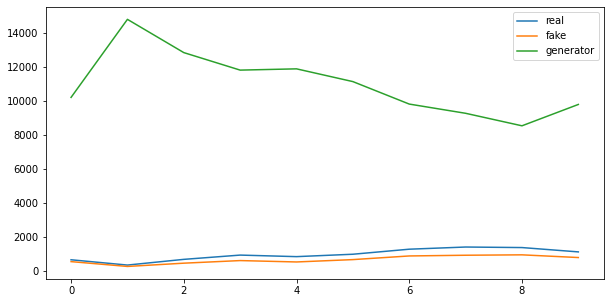

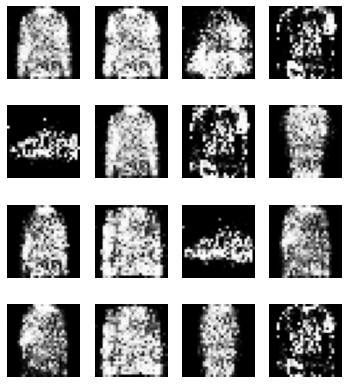

CPU times: user 4min 9s, sys: 12.1 s, total: 4min 21s
Wall time: 4min 14s


In [51]:
%%time
generator = CondGenerator()
discriminator = CondDiscriminator()
criterion = nn.BCELoss()
ERRD_x, ERRD_z, ERRG = train(generator, discriminator, criterion, with_cat=True)
plot_loss(ERRD_x, ERRD_z, ERRG)
make_samples(generator, with_cat=True)

### Выводы

Сети DCGAN и LSGAN требуют гораздо больше времени на обучение, и при этом показывают результаты гораздо хуже обычного GAN на данном датасете. LSGAN показывает хоть что-то похожее на исходные изображения, когда DCGAN генерирует непонятно что.